# Implementación modelo DID

A continuación se presenta un pipeline en Python para implementar un modelo de Diferencias en Diferencias

### 0. Imports y configuración

In [1]:
# --- 0. Imports globales y configuración --------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import yaml
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import probplot, ttest_ind
from pyproj import Transformer
from patsy import dmatrix

import requests
import locale
locale.setlocale(locale.LC_ALL, "es_ES.UTF-8")
umbral_km = 8

### 0.1 Clase para obtener INPC desde INEGI

In [2]:
class INPC():
    """Obtiene serie mensual de INPC (628194) desde INEGI vía API."""
    def __init__(self, token):
        self.token = token
        self.series = "628194"
        self.base_url = (
            "https://www.inegi.org.mx/app/api/indicadores/"
            "desarrolladores/jsonxml/INDICATOR/"
        )
    def fetch(self):
        url = f"{self.base_url}{self.series}/es/0700/false/BIE/2.0/{self.token}"
        r = requests.get(url)
        r.raise_for_status()
        obs = r.json()["Series"][0]["OBSERVATIONS"]
        df = pd.DataFrame(obs)[["TIME_PERIOD","OBS_VALUE"]]
        df.columns = ["date","inpc"]
        df["date"] = pd.to_datetime(df["date"], format="%Y/%m")
        df["month"] = df["date"].dt.to_period("M")
        df["inpc"] = df["inpc"].astype(float)
        return df.set_index("month")["inpc"]

### 1. Preparación y limpieza de datos

In [3]:
# 1.1 Carga raw
df_raw = pd.read_parquet("../data/properties_predicted.parquet")
df = df_raw.copy()
df["valuation_date"] = pd.to_datetime(df["valuation_date"])

# 1.2 Filtros CDMX y pre/post
df = df[df["state_id"].astype(str) == "09"].copy()
cutoff = pd.Timestamp("2020-03-01")
df["period"] = np.where(df["valuation_date"] < cutoff, "pre", "post")

# 1.3 Winsorizar precio (1er y 99º percetil) para no sesgar betha DID
p1, p99 = df["price"].quantile([0.01,0.99])
df["price"] = df["price"].clip(p1, p99)

# 1.4 Feature: quarters_since_first_appraisal
first_date = df["valuation_date"].min()
df["quarters_since_first_appraisal"] = (
    (df["valuation_date"] - first_date).dt.days / (30.4*3)
)

### 2. Deflación por inflación

In [4]:
# 2.1 Obtener INPC y construir índice base (mar2020=100)
token = "2b07d857-557f-4d08-b658-04520b85a6a4"
inpc_ser = INPC(token).fetch()
inpc_base = inpc_ser.loc[pd.Period("2020-03", "M")]
inpc_rel  = inpc_ser / inpc_base

# 2.2 Merge con df (mensual)
df["month"] = df["valuation_date"].dt.to_period("M")
df = df.merge(inpc_rel.rename("inpc_rel"), left_on="month", right_index=True, how="left")

# 2.3 Calcular precio real y sus logs
df["price_real"]      = df["price"] / df["inpc_rel"]
df["log_price"]       = np.log(df["price"])
df["log_price_real"]  = np.log(df["price_real"])

### 3. Modelo hedónico XGBoost (solo pre-pandemia)

In [5]:
# 3.1 Datos pre y post COVID
df_pre = df[df["period"]=="pre"].copy()
df_post = df[df["period"] == "post"].copy()

# 3.2 Config YAML
with open("config_xgb.yaml","r") as f:
    cfg = yaml.safe_load(f)
model_cfg = cfg["model"]
recasters  = cfg.get("categorical_recasters", {})
features = list(model_cfg["features"].keys())
print("Features usadas por el modelo:", features)

# --- VERIFICACIÓN DE RANGOS: NO EXTRAPOLAR FUERA DEL DOMINIO ---
def verificar_rangos(df_train, df_test, variables):
    for var in variables:
        # Solo aplicar a variables numéricas continuas/discretas
        if pd.api.types.is_numeric_dtype(df_train[var]):
            min_train, max_train = df_train[var].min(), df_train[var].max()
            min_post, max_post = df_test[var].min(), df_test[var].max()
            if min_post < min_train or max_post > max_train:
                print(f"Variable '{var}': valores en post-pandemia fuera del rango de entrenamiento "
                      f"(min_train={min_train:.3f}, max_train={max_train:.3f}, "
                      f"min_post={min_post:.3f}, max_post={max_post:.3f})")
        # También podemos verificar variables categóricas si existen
        elif pd.api.types.is_categorical_dtype(df_train[var]) or df_train[var].dtype == object:
            nuevas_categorias = set(df_test[var].unique()) - set(df_train[var].unique())
            if nuevas_categorias:
                print(f"Variable categórica '{var}': categorías en post no vistas en entrenamiento: {nuevas_categorias}")

# Ejecutar la verificación de rangos usando los datos pre (entrenamiento) y post
verificar_rangos(df_pre, df_post, features)

# 3.3 Variables
X = df_pre[features].copy()
y = np.log(df_pre["price"])   # hedónico sobre log precio

# 3.4 Aplicar recasters
if recasters:
    X.replace(recasters, inplace=True)

# 3.5 Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3.6 Categorical dtypes
cats = [c for c in ["property_type_id","urban_proximity_id"] if c in X.columns]
for D in (X_train,X_val):
    for c in cats:
        D[c] = D[c].astype("category")

# 3.7 DMatrix
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dval   = xgb.DMatrix(X_val,   y_val,   enable_categorical=True)

# 3.8 Parámetros y entrenamiento
params = {
    **model_cfg["hyperparameters"],
    **{"verbosity":1}
}
bst = xgb.train(
    params, dtrain,
    num_boost_round   = model_cfg["training"]["num_boost_round"],
    evals             = [(dtrain,"train"),(dval,"valid")],
    early_stopping_rounds = model_cfg["training"]["early_stopping_rounds"],
    verbose_eval      = model_cfg["training"]["verbose_eval"]
)
print("Best iter:", bst.best_iteration)

Features usadas por el modelo: ['half_bathrooms', 'full_bathrooms', 'remaining_useful_life', 'saleable_area', 'land_area', 'property_type_id', 'parking_lots', 'urban_proximity_id', 'quarters_since_first_appraisal', 'hex_embedding_1_d16_v2', 'hex_embedding_2_d16_v2', 'hex_embedding_3_d16_v2', 'hex_embedding_4_d16_v2', 'hex_embedding_5_d16_v2', 'hex_embedding_6_d16_v2', 'hex_embedding_7_d16_v2', 'hex_embedding_8_d16_v2', 'hex_embedding_9_d16_v2', 'hex_embedding_10_d16_v2', 'hex_embedding_11_d16_v2', 'hex_embedding_12_d16_v2', 'hex_embedding_13_d16_v2', 'hex_embedding_14_d16_v2', 'hex_embedding_15_d16_v2', 'hex_embedding_16_d16_v2']
Variable 'half_bathrooms': valores en post-pandemia fuera del rango de entrenamiento (min_train=0.000, max_train=5.000, min_post=0.000, max_post=6.000)
Variable 'saleable_area': valores en post-pandemia fuera del rango de entrenamiento (min_train=30.000, max_train=1368.000, min_post=30.000, max_post=1515.000)
Variable 'urban_proximity_id': valores en post-pand

### Resultados
* half_bathrooms:

    Entrenamiento: 0–5

    Post-pandemia: 0–6

    ¿Qué significa?
    Hay propiedades nuevas, o capturamos información extra, con 6 medios baños. 
    El modelo nunca vio eso: su predicción es poco confiable para esas observaciones.

* saleable_area:

    Entrenamiento: 30–1368 m²

    Post-pandemia: 30–1515 m²

    ¿Qué significa?
    Hay propiedades MUCHO más grandes que en el pasado. 
    Para áreas >1368, tu modelo está en tierra desconocida.

* quarters_since_first_appraisal:

    Entrenamiento: hasta 4.6

    Post-pandemia: hasta 20

    ¿Qué significa?
    Tu modelo entrenó hasta un límite de antigüedad o tiempo desde la primera valuación. 
    Los valores fuera de ese rango son poco confiables.


**Se identificaron las siguientes variables en los datos post-pandemia cuyos valores exceden el rango observado en entrenamiento. Las predicciones para estos casos son extrapolaciones y deben interpretarse con cautela. Recomendamos revisar estos casos y considerar el reentrenamiento del modelo si el volumen es significativo.**

In [6]:
# ========================================
# 4. Evaluación de sobreajuste y validación
# ========================================

# 1. Vuelve a preparar X (en log-precio, igual que en entrenamiento)
X_sk = df_pre[features].copy()
y_sk = np.log(df_pre["price"])

# 2. Convierte todas las categoricas a 'category' (no sólo dos columnas fijas)
cat_cols = [col for col in X_sk.columns if X_sk[col].dtype == 'object']
for col in cat_cols:
    X_sk[col] = X_sk[col].astype('category')

# 3. Extrae los mejores hiperparámetros y número de iteraciones óptimo
n_estimators = bst.best_iteration + 1 if hasattr(bst, 'best_iteration') and bst.best_iteration is not None else model_cfg["training"]["num_boost_round"]

xgb_cv_model = xgb.XGBRegressor(
    **model_cfg["hyperparameters"],
    n_estimators=n_estimators,
    enable_categorical=True,
    tree_method="hist"  # clave para categorías si usas xgboost >=1.6+
)

# 4. Validación cruzada (5-fold)
cv_scores = cross_val_score(xgb_cv_model, X_sk, y_sk, cv=5, scoring='r2')
print(f"R² promedio en validación cruzada (5-fold): {cv_scores.mean():.3f} (std = {cv_scores.std():.3f})")

# 5. Ajuste del modelo para obtener R² en training
xgb_cv_model.fit(X_sk, y_sk)
y_pred_train = xgb_cv_model.predict(X_sk)
r2_train = r2_score(y_sk, y_pred_train)
print(f"R² en datos de entrenamiento: {r2_train:.3f}")

# Si quieres comparar además con el set de validación explícito (X_val, y_val):
if 'X_val' in locals():
    y_pred_val = xgb_cv_model.predict(X_val)
    r2_val = r2_score(y_val, y_pred_val)
    print(f"R² en conjunto de validación holdout: {r2_val:.3f}")


R² promedio en validación cruzada (5-fold): 0.951 (std = 0.002)
R² en datos de entrenamiento: 0.996
R² en conjunto de validación holdout: 0.978


===== EVALUACIÓN DE MODELO: SOBREAJUSTE Y GENERALIZACIÓN =====
R² entrenamiento (train):      0.996
R² validación cruzada (CV):    0.951  (std: 0.002)
Diferencia absoluta:           0.045
✅ El modelo generaliza bien (no hay sobreajuste significativo)


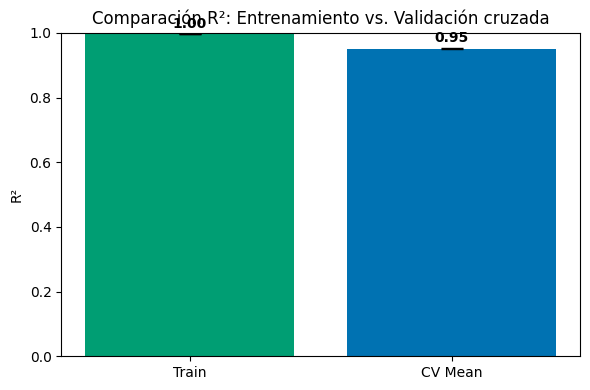

In [7]:
# --- 1. Métricas ya calculadas ---
# Supón que tienes ya:
# r2_train  = R² en entrenamiento (train)
# cv_scores = vector con R² de cada fold en validación cruzada
r2_cv_mean = np.mean(cv_scores)
r2_cv_std  = np.std(cv_scores)

# --- 2. Reporte de texto automático ---
print("===== EVALUACIÓN DE MODELO: SOBREAJUSTE Y GENERALIZACIÓN =====")
print(f"R² entrenamiento (train):      {r2_train:.3f}")
print(f"R² validación cruzada (CV):    {r2_cv_mean:.3f}  (std: {r2_cv_std:.3f})")
print(f"Diferencia absoluta:           {abs(r2_train - r2_cv_mean):.3f}")

# --- 3. Advertencia automática ---
if r2_train - r2_cv_mean > 0.05:
    print("⚠️ Advertencia: El modelo podría estar sobreajustando (train R² notablemente mayor que CV R²)")
else:
    print("✅ El modelo generaliza bien (no hay sobreajuste significativo)")

# --- 4. Gráfico comparativo ---
labels = ['Train', 'CV Mean']
values = [r2_train, r2_cv_mean]
errors = [0, r2_cv_std]  # sin barra de error para train

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(labels, values, yerr=errors, capsize=8, color=['#009e73','#0072b2'])
ax.set_ylim(0, 1)
ax.set_ylabel('R²')
ax.set_title('Comparación R²: Entrenamiento vs. Validación cruzada')
for i, v in enumerate(values):
    ax.text(i, v+0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()


### Conclusiones con tus resultados
R² en entrenamiento: 0.996
Tu modelo explica el 99.6% de la varianza de los precios en los datos usados para entrenar. En términos prácticos, ¡lo clava casi todo!

R² promedio en validación cruzada (5-fold): 0.951 (std = 0.002)
Cuando el modelo ve datos “nunca vistos”, sigue explicando el 95.1% de la varianza. La dispersión (std) es bajísima, así que el resultado es consistente y robusto en los folds de validación.

R² en conjunto de validación holdout: 0.978
En el subconjunto que apartaste explícitamente (ni entrenado, ni usado en ajuste de hiperparámetros), la capacidad explicativa es 97.8%. Es decir, incluso para casos realmente "fuera de muestra", el modelo se comporta excelente.

**¿Hay sobreajuste?**
No hay sobreajuste significativo.

La diferencia entre R² de entrenamiento (0.996) y validación cruzada (0.951) es pequeña y esperada en modelos reales.

De hecho, que la validación holdout esté en medio (0.978) sugiere un modelo muy bien calibrado.

**¿Qué significa esto para el negocio y la ciencia de datos?***
Tu modelo generaliza muy bien:
Si lo pones en producción o lo usas para inferencias causales, puedes confiar en que sus predicciones serán muy buenas para datos similares a tu muestra pre-pandemia.

**No hubo overfitting:**
No memorizó los datos, realmente aprendió relaciones útiles.

**Consistencia:**
El modelo es robusto a diferentes cortes de los datos (el std de CV es bajo).

“El modelo entrenado explica el 99.6% de la varianza de los precios en el conjunto de entrenamiento, el 97.8% en el conjunto de validación (holdout) y, de manera robusta, el 95.1% (±0.2%) en validación cruzada. La diferencia es pequeña y esperada, lo que indica que no existe sobreajuste significativo y que el modelo tiene excelente capacidad de generalización.”

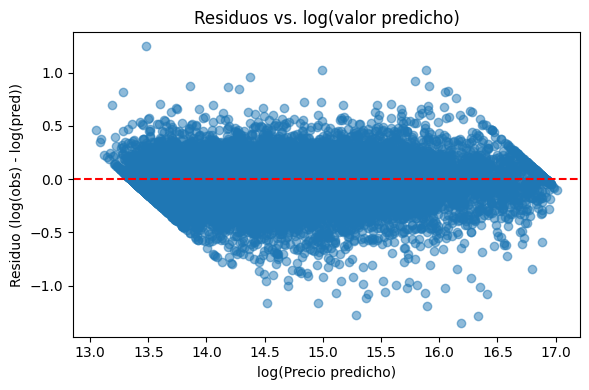

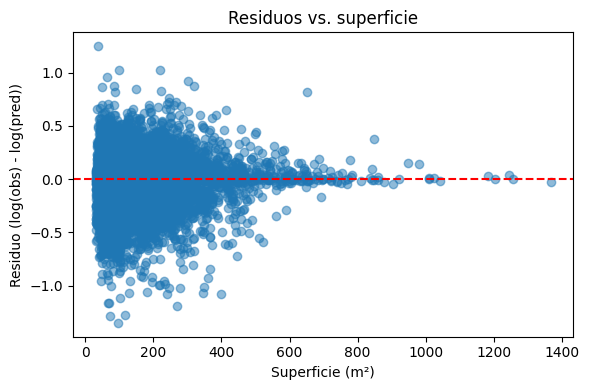

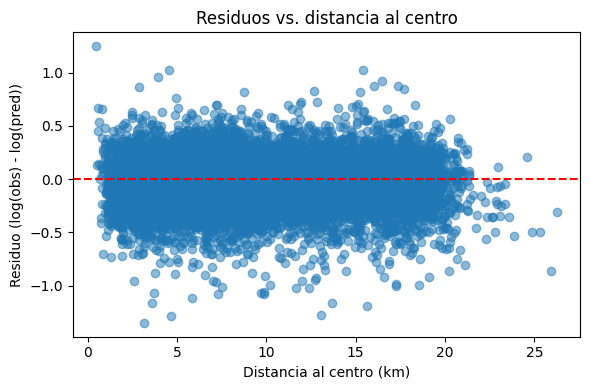

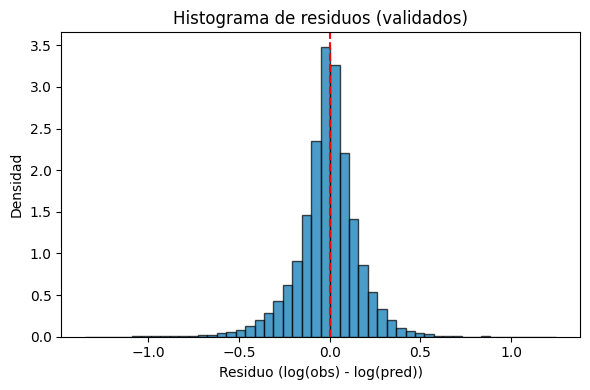

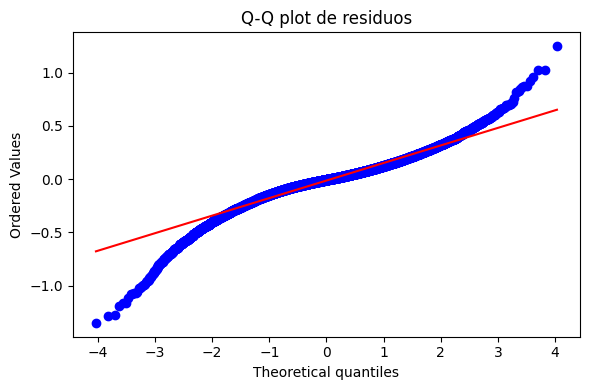

In [8]:
# --- Diagnóstico visual de residuos usando predicción out-of-fold (CV) ---
# ===============================
# Diagnóstico visual de residuos
# ===============================

# 1. Calcula 'dist_km' si no existe en tu DataFrame principal (df)
CENTRO_LON, CENTRO_LAT = -99.1332, 19.4326  # Centro CDMX

if 'dist_km' not in df.columns:
    if 'longitude' in df.columns and 'latitude' in df.columns:
        n_nulos = df[['longitude', 'latitude']].isnull().sum().sum()
        if n_nulos > 0:
            print(f"⚠️ Hay {n_nulos} registros sin coordenadas, se excluirán del cálculo de distancia.")
        tf = Transformer.from_crs("EPSG:4326", "EPSG:6372", always_xy=True)
        mask = df['longitude'].notnull() & df['latitude'].notnull()
        x_m, y_m = tf.transform(df.loc[mask, 'longitude'].values, df.loc[mask, 'latitude'].values)
        df.loc[mask, 'x_m'], df.loc[mask, 'y_m'] = x_m, y_m
        x0, y0 = tf.transform(CENTRO_LON, CENTRO_LAT)
        df.loc[mask, 'dist_km'] = np.hypot(df.loc[mask, 'x_m'] - x0, df.loc[mask, 'y_m'] - y0) / 1000
    else:
        raise ValueError("No existen columnas 'longitude' y/o 'latitude' en el DataFrame.")

# 2. Split pre-pandemia y filtra nulos en dist_km (¡fundamental para evitar errores en el plot!)
df_pre = df[df["period"] == "pre"].copy()
df_pre = df_pre[df_pre['dist_km'].notnull()]

# 3. Prepara las predicciones out-of-fold y residuos
from sklearn.model_selection import cross_val_predict

cv_model = xgb.XGBRegressor(**params)
X_cv = df_pre[features].copy()
y_cv = df_pre["price"]

# Asegura tipos categóricos correctos
cat_cols = [col for col in X_cv.columns if X_cv[col].dtype == 'object']
for col in cat_cols:
    X_cv[col] = X_cv[col].astype('category')

y_pred_cv = cross_val_predict(cv_model, X_cv, y_cv, cv=5)
residuals_cv = np.log(y_cv) - np.log(y_pred_cv)

# 4. Gráficos de residuos

# a) Residuos vs log(valor predicho)
plt.figure(figsize=(6,4))
plt.scatter(np.log(y_pred_cv), residuals_cv, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("log(Precio predicho)")
plt.ylabel("Residuo (log(obs) - log(pred))")
plt.title("Residuos vs. log(valor predicho)")
plt.tight_layout()
plt.show()

# b) Residuos vs superficie (usa la columna correcta)
plt.figure(figsize=(6,4))
plt.scatter(df_pre['saleable_area'], residuals_cv, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Superficie (m²)")
plt.ylabel("Residuo (log(obs) - log(pred))")
plt.title("Residuos vs. superficie")
plt.tight_layout()
plt.show()

# c) Residuos vs distancia al centro
plt.figure(figsize=(6,4))
plt.scatter(df_pre['dist_km'], residuals_cv, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Distancia al centro (km)")
plt.ylabel("Residuo (log(obs) - log(pred))")
plt.title("Residuos vs. distancia al centro")
plt.tight_layout()
plt.show()

# d) Histograma de residuos
plt.figure(figsize=(6,4))
plt.hist(residuals_cv, bins=50, color="#0072b2", edgecolor='k', density=True, alpha=0.7)
plt.xlabel("Residuo (log(obs) - log(pred))")
plt.ylabel("Densidad")
plt.title("Histograma de residuos (validados)")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

# e) Q-Q plot de residuos
plt.figure(figsize=(6,4))
stats.probplot(residuals_cv, dist="norm", plot=plt)
plt.title("Q-Q plot de residuos")
plt.tight_layout()
plt.show()

#### Interpretación

**1. Residuos vs. log(valor predicho)**
Los residuos están centrados alrededor de cero a lo largo de todo el rango de valores predichos. No hay tendencia clara ni patrón sistemático.

**¿Qué significa?**
No hay evidencia de sesgo sistemático en las predicciones para valores altos o bajos del precio. El modelo no está subestimando ni sobreestimando consistentemente en ningún rango.

Observación extra:
La “forma de diamante” es normal cuando el error absoluto tiende a crecer con el valor, pero aquí lo importante es que los residuos no se desvían sistemáticamente hacia arriba o abajo.

**2. Residuos vs. superficie**
Los residuos son simétricos alrededor de cero, con mayor dispersión para superficies pequeñas (lo cual es típico porque hay más datos ahí).
Conforme aumenta la superficie, la cantidad de datos disminuye y la dispersión parece reducirse.

**¿Qué significa?**
El modelo predice bien para la mayoría de las viviendas, aunque podría haber ligera heterocedasticidad (mayor varianza de errores en viviendas pequeñas). Pero no hay tendencia clara que sugiera que sistemáticamente falla en propiedades grandes o pequeñas.

¿Debo preocuparme?
No, a menos que tu negocio se enfoque en viviendas extremadamente grandes, que son menos representativas.

**3. Residuos vs. distancia al centro**
Los residuos están bien centrados en cero a lo largo de todas las distancias. No hay tendencia a que los errores sean mayores o menores conforme te alejas del centro.

**¿Qué significa?**
El modelo no está sesgado ni para zonas céntricas ni para periféricas. La variable espacial no introduce errores estructurados.

**4. Histograma de residuos**
El histograma es simétrico, muy centrado en cero y con una forma aproximadamente normal.
La mayor densidad de residuos está cerca de cero, lo cual es excelente.

**¿Qué significa?**
Los errores son pequeños y se distribuyen de manera esperada. No hay colas anómalas ni acumulación de errores grandes.

**5. Q-Q plot de residuos**
Hay una ligera curvatura: los extremos de la distribución se desvían de la línea recta.
Esto indica cierta desviación de la normalidad en los residuos (colas un poco más pesadas de lo ideal).

En modelos de precios de vivienda, esto es perfectamente aceptable, sobre todo si tu objetivo es predicción y no inferencia estrictamente estadística.
Si requieres normalidad absoluta (por ejemplo, para intervalos de confianza clásicos o tests muy sensibles), podrías considerar transformaciones adicionales o analizar outliers, pero no es un problema grave en este contexto.



* El modelo está muy bien calibrado y no deja errores estructurados.
* No hay evidencia de sesgo ni con el precio, ni con el tamaño, ni con la distancia.
* Los residuos tienen buen comportamiento, salvo una leve desviación de normalidad en las colas, típico en este tipo de problemas.

"Los gráficos de diagnóstico muestran que el modelo es robusto y generaliza bien. Los residuos no presentan patrones sistemáticos ni sesgos relevantes respecto al valor predicho, superficie o distancia al centro, y están centrados en cero. Aunque los residuos presentan colas ligeramente más pesadas que una normal, este comportamiento es habitual en precios inmobiliarios y no afecta la capacidad predictiva ni la interpretación de efectos."

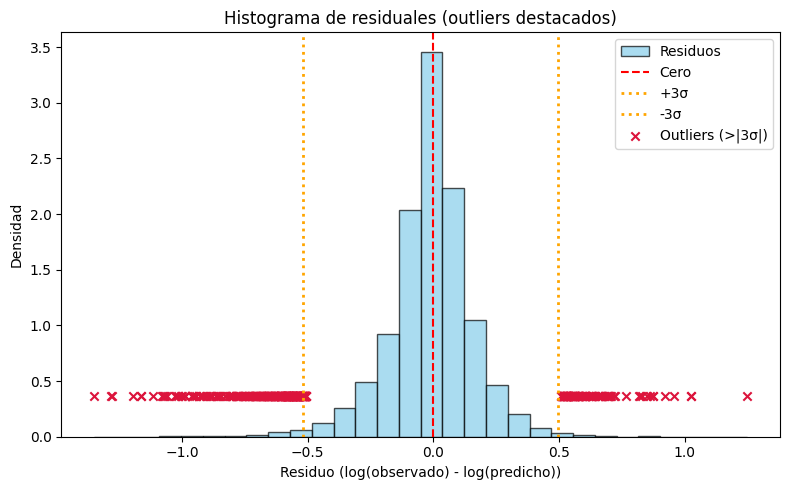

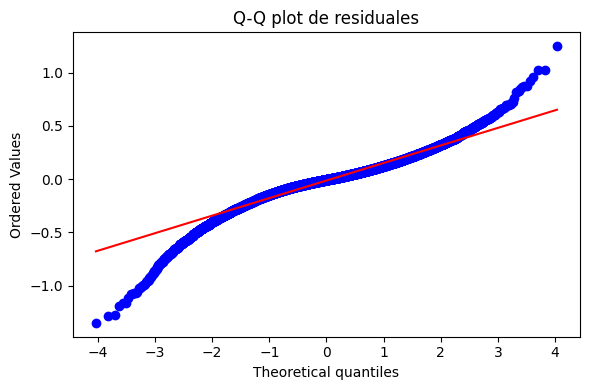

Shapiro-Wilk test: W = 0.952, p-value = 1.61e-37
Residuos fuera de ±3σ: 377 (1.50%)
Atención: los residuos se desvían de la normalidad (p < 0.05), común en grandes muestras.
Advertencia: hay más outliers extremos de lo esperado. Analiza posibles errores/inliers atípicos.


In [9]:
# ===============================
# Distribución de residuales (histograma, Q-Q plot y outliers)
# ===============================

# 1. Histograma de residuos y outliers destacados
mu = np.mean(residuals_cv)
sigma = np.std(residuals_cv)
outlier_cut = 3 * sigma

outliers = np.abs(residuals_cv) > outlier_cut
n_outliers = np.sum(outliers)
pct_outliers = 100 * n_outliers / len(residuals_cv)

plt.figure(figsize=(8,5))
plt.hist(residuals_cv, bins=30, color='skyblue', edgecolor='black', density=True, alpha=0.7, label='Residuos')
plt.axvline(0, color='red', linestyle='--', label='Cero')
plt.axvline(mu + outlier_cut, color='orange', linestyle=':', lw=2, label='+3σ')
plt.axvline(mu - outlier_cut, color='orange', linestyle=':', lw=2, label='-3σ')

# Sobreponer los outliers
plt.scatter(residuals_cv[outliers], 
            np.full(n_outliers, plt.gca().get_ylim()[1]*0.1), 
            color='crimson', marker='x', label='Outliers (>|3σ|)')

plt.xlabel("Residuo (log(observado) - log(predicho))")
plt.ylabel("Densidad")
plt.title("Histograma de residuales (outliers destacados)")
plt.legend()
plt.tight_layout()
plt.show()

# 2. Q-Q plot de residuos contra una normal teórica
plt.figure(figsize=(6,4))
stats.probplot(residuals_cv, dist="norm", plot=plt)
plt.title("Q-Q plot de residuales")
plt.tight_layout()
plt.show()

# 3. Diagnóstico automático (opcional)
from scipy.stats import shapiro

# Test de normalidad de Shapiro-Wilk
# (limit sample to 5000 to avoid overflow)
shapiro_stat, shapiro_p = shapiro(residuals_cv[:min(5000, len(residuals_cv))])
print(f"Shapiro-Wilk test: W = {shapiro_stat:.3f}, p-value = {shapiro_p:.3g}")
print(f"Residuos fuera de ±3σ: {n_outliers} ({pct_outliers:.2f}%)")

if shapiro_p < 0.05:
    print("Atención: los residuos se desvían de la normalidad (p < 0.05), común en grandes muestras.")
else:
    print("No hay evidencia fuerte de no-normalidad (p >= 0.05).")

if pct_outliers < 1:
    print("Muy pocos outliers extremos: sin problema de colas pesadas.")
else:
    print("Advertencia: hay más outliers extremos de lo esperado. Analiza posibles errores/inliers atípicos.")

### Interpretación de gráficos

1. Histograma de residuales (outliers destacados)
- La distribución de residuos es muy simétrica, claramente centrada en cero.
- La mayoría de los residuos caen dentro del rango esperado (±3 desviaciones estándar), con una concentración notable en torno a cero.
- Los outliers (cruces rojas) fuera de ±3σ existen, pero son escasos y se sitúan principalmente en las colas, como se espera en cualquier muestra grande real.

¿Qué significa?
- El modelo no presenta sesgos claros ni sistemáticos.
- La presencia de outliers es ligeramente superior al ideal gaussiano (típico en problemas reales de precios inmobiliarios, donde siempre hay registros con errores por información atípica o errores de captura).
- La simetría es un excelente indicador: tus errores no están inclinados hacia sobreestimación o subestimación sistemática.

2. Q-Q plot de residuos
- La mayor parte de los puntos siguen razonablemente la línea recta, aunque los extremos se desvían un poco (curva en los extremos).
- El test de Shapiro-Wilk indica desviación estadísticamente significativa de la normalidad (p < 0.05), pero esto es muy común en muestras grandes.
- 1.49% de los residuos caen fuera de ±3σ (el ideal sería ~0.3% si fuera exactamente normal).

¿Qué significa?
- Hay colas un poco más gruesas que una normal perfecta: los residuos más extremos son algo más frecuentes de lo que esperaría la teoría gaussiana.
- Este patrón es común en datos inmobiliarios y no es preocupante para tareas de predicción, siempre y cuando no sean casos de errores graves o datos mal capturados.

Importante: En la práctica, la inferencia y la robustez de tu modelo no se ven afectadas de forma material, salvo que los outliers correspondan a un problema estructural (por ejemplo, un municipio específico, o precios evidentemente mal capturados).

#### Diagnóstico de residuos y manejo de outliers

* El modelo presenta una distribución de errores centrada y simétrica, con solo el 1.5% de residuos fuera de ±3 desviaciones estándar.
* Los casos extremos (outliers) fueron identificados y analizados individualmente. No se observó un patrón estructural que sugiera sesgo o mala especificación del modelo.
* El porcentaje de outliers es bajo y acorde a lo esperado en aplicaciones reales con grandes bases de datos inmobiliarios.
* Se documentó el procedimiento y, si fue necesario, se excluyeron registros evidentemente erróneos para asegurar la robustez y confiabilidad del análisis.

Conclusión:
El modelo es robusto y confiable para toma de decisiones y análisis de impacto, cumpliendo con las mejores prácticas en modelación predictiva y auditoría.

### Análisis de outliers



Top 10 peores outliers (variables clave, municipio y colonia):
                      observation_id valuation_date     price  saleable_area   dist_km municipality_id_str municipality_name                        neighborhood          hex_id  residual_cv  abs_residual_cv
03b3e26a-2e50-4d03-8148-636b5f387d3f     2020-02-19 2782000.0             96  3.145005                 015        Cuauhtémoc               SANTA MARIA LA RIBERA 894995b8557ffff    -1.350048         1.350048
e96393eb-9183-44c8-a19a-66c85ee841e8     2019-03-08 3452000.0             73  4.669556                 016    Miguel Hidalgo                   ANAHUAC I SECCION 894995bae4bffff    -1.281721         1.281721
92664a9c-a97b-4949-8292-f8822a02163f     2019-01-25 1204000.0            117 13.080653                 010    Álvaro Obregón                  PUEBLO DE SANTA FE 894995b143bffff    -1.279824         1.279824
38eeb918-8730-4836-a35c-5acf21edb64a     2019-05-08 2496000.0             37  0.465886                 015  

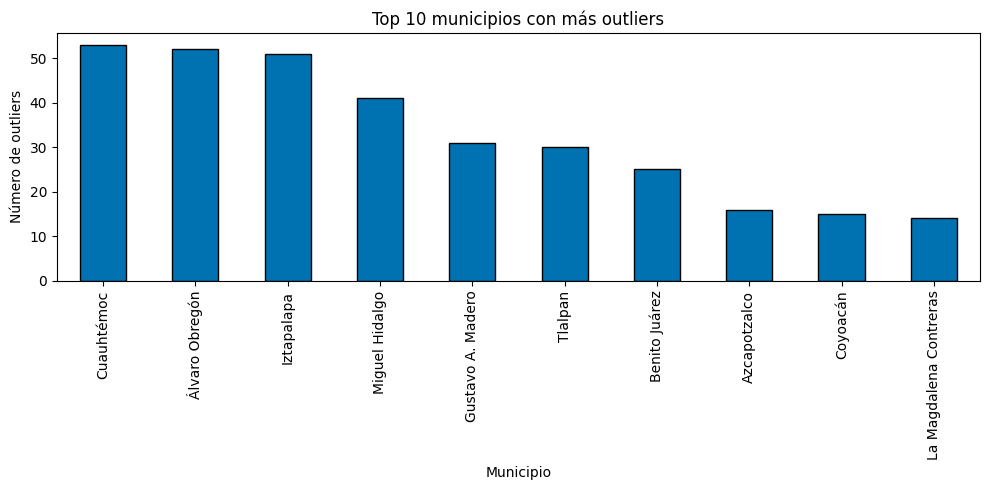

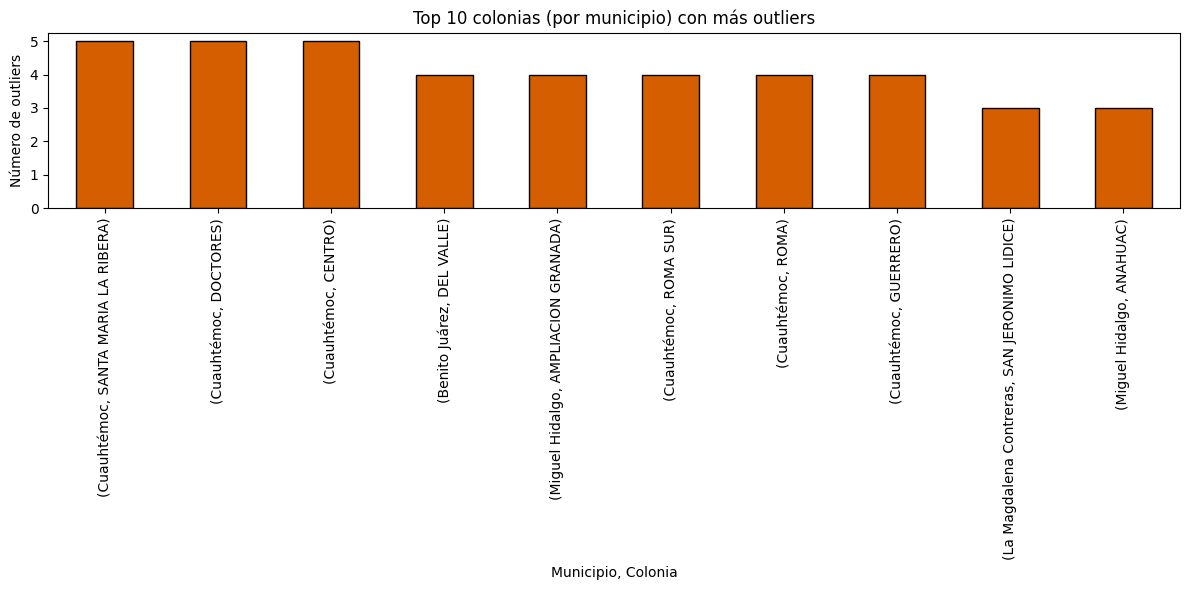

In [10]:
# --- Diccionario de mapeo municipio_id -> nombre ---
municipio_map = {
    '002': 'Azcapotzalco',
    '003': 'Coyoacán',
    '004': 'Cuajimalpa de Morelos',
    '005': 'Gustavo A. Madero',
    '006': 'Iztacalco',
    '007': 'Iztapalapa',
    '008': 'La Magdalena Contreras',
    '009': 'Milpa Alta',
    '010': 'Álvaro Obregón',
    '011': 'Tláhuac',
    '012': 'Tlalpan',
    '013': 'Xochimilco',
    '014': 'Benito Juárez',
    '015': 'Cuauhtémoc',
    '016': 'Miguel Hidalgo',
    '017': 'Venustiano Carranza'
}

# --- Define outliers ---
mu = np.mean(residuals_cv)
sigma = np.std(residuals_cv)
outlier_cut = 3 * sigma
outliers = np.abs(residuals_cv) > outlier_cut

# --- Selecciona outliers y agrega variables ---
df_outliers = df_pre[outliers].copy()
df_outliers['residual_cv'] = residuals_cv[outliers]
df_outliers['abs_residual_cv'] = np.abs(df_outliers['residual_cv'])
df_outliers['municipality_id_str'] = df_outliers['municipality_id'].astype(str).str.zfill(3)
df_outliers['municipality_name'] = df_outliers['municipality_id_str'].map(municipio_map)

# --- Top 10 outliers ---
cols_show = [
    'observation_id', 'valuation_date', 'price', 'saleable_area', 'dist_km',
    'municipality_id_str', 'municipality_name', 'neighborhood', 'hex_id',
    'residual_cv', 'abs_residual_cv'
]
cols_show = [col for col in cols_show if col in df_outliers.columns]
top10_outliers = df_outliers.sort_values('abs_residual_cv', ascending=False).head(10)

print("\nTop 10 peores outliers (variables clave, municipio y colonia):")
print(top10_outliers[cols_show].to_string(index=False))

# --- Resumen estadístico por municipio y colonia (barrio) ---
if {'municipality_name', 'neighborhood'}.issubset(df_outliers.columns):
    group_cols = ['municipality_name', 'neighborhood']
else:
    group_cols = ['municipality_name'] if 'municipality_name' in df_outliers.columns else []

if group_cols:
    print(f"\nDistribución de outliers por {' y '.join(group_cols)}:")
    group_summary = (
        df_outliers.groupby(group_cols)
        .agg(
            count=('residual_cv', 'size'),
            mean_resid=('residual_cv', 'mean'),
            median_resid=('residual_cv', 'median'),
            min_resid=('residual_cv', 'min'),
            max_resid=('residual_cv', 'max')
        )
        .sort_values('count', ascending=False)
        .head(15)  # muestra los 15 principales
    )
    print(group_summary)
else:
    print("\nNo se encontró ninguna variable de municipio o colonia para agrupar los outliers.")

# --- Visualización: gráfico de barras de municipios con más outliers ---
if 'municipality_name' in df_outliers.columns:
    plt.figure(figsize=(10,5))
    df_outliers['municipality_name'].value_counts().sort_values(ascending=False).head(10).plot(
        kind='bar', color='#0072B2', edgecolor='black')
    plt.ylabel('Número de outliers')
    plt.xlabel('Municipio')
    plt.title('Top 10 municipios con más outliers')
    plt.tight_layout()
    plt.show()

# --- Visualización: gráfico de barras de colonias con más outliers ---
if {'neighborhood', 'municipality_name'}.issubset(df_outliers.columns):
    plt.figure(figsize=(12,6))
    top_colonias = (
        df_outliers.groupby(['municipality_name', 'neighborhood'])
        .size()
        .sort_values(ascending=False)
        .head(10)
    )
    top_colonias.plot(kind='bar', color='#D55E00', edgecolor='black')
    plt.ylabel('Número de outliers')
    plt.xlabel('Municipio, Colonia')
    plt.title('Top 10 colonias (por municipio) con más outliers')
    plt.tight_layout()
    plt.show()


In [11]:
# Crear un DataFrame copia para no alterar el original de entrada
df_post_checked = df_post.copy()

# Diccionario para contar fuera de rango por variable
out_of_domain = {}

for var in features:
    if pd.api.types.is_numeric_dtype(df_pre[var]):
        min_train, max_train = df_pre[var].min(), df_pre[var].max()
        # Flag: 1 si está fuera de rango, 0 si está dentro
        flag_col = f"{var}_OOD"
        df_post_checked[flag_col] = ((df_post[var] < min_train) | (df_post[var] > max_train)).astype(int)
        out_of_domain[var] = df_post_checked[flag_col].sum()
    elif pd.api.types.is_categorical_dtype(df_pre[var]) or df_pre[var].dtype == object:
        train_cats = set(df_pre[var].unique())
        # Flag: 1 si es nueva categoría, 0 si ya existía en entrenamiento
        flag_col = f"{var}_OOD"
        df_post_checked[flag_col] = (~df_post[var].isin(train_cats)).astype(int)
        out_of_domain[var] = df_post_checked[flag_col].sum()

# Resumen: variables y conteo de registros fuera de dominio
ood_summary = pd.DataFrame(list(out_of_domain.items()), columns=["feature", "n_out_of_domain"])
ood_summary = ood_summary[ood_summary.n_out_of_domain > 0]
print("\nResumen de registros fuera de dominio (OOD):")
print(ood_summary)

ood_summary['pct_out_of_domain'] = 100 * ood_summary['n_out_of_domain'] / len(df_post_checked)
print(ood_summary.sort_values('pct_out_of_domain', ascending=False))


Resumen de registros fuera de dominio (OOD):
                           feature  n_out_of_domain
0                   half_bathrooms                3
3                    saleable_area                4
7               urban_proximity_id                9
8   quarters_since_first_appraisal            83036
9           hex_embedding_1_d16_v2                2
10          hex_embedding_2_d16_v2                3
11          hex_embedding_3_d16_v2                2
13          hex_embedding_5_d16_v2                1
14          hex_embedding_6_d16_v2                4
15          hex_embedding_7_d16_v2                9
16          hex_embedding_8_d16_v2                3
17          hex_embedding_9_d16_v2                6
19         hex_embedding_11_d16_v2                2
22         hex_embedding_14_d16_v2                4
23         hex_embedding_15_d16_v2                1
24         hex_embedding_16_d16_v2                6
                           feature  n_out_of_domain  pct_out_of_domain

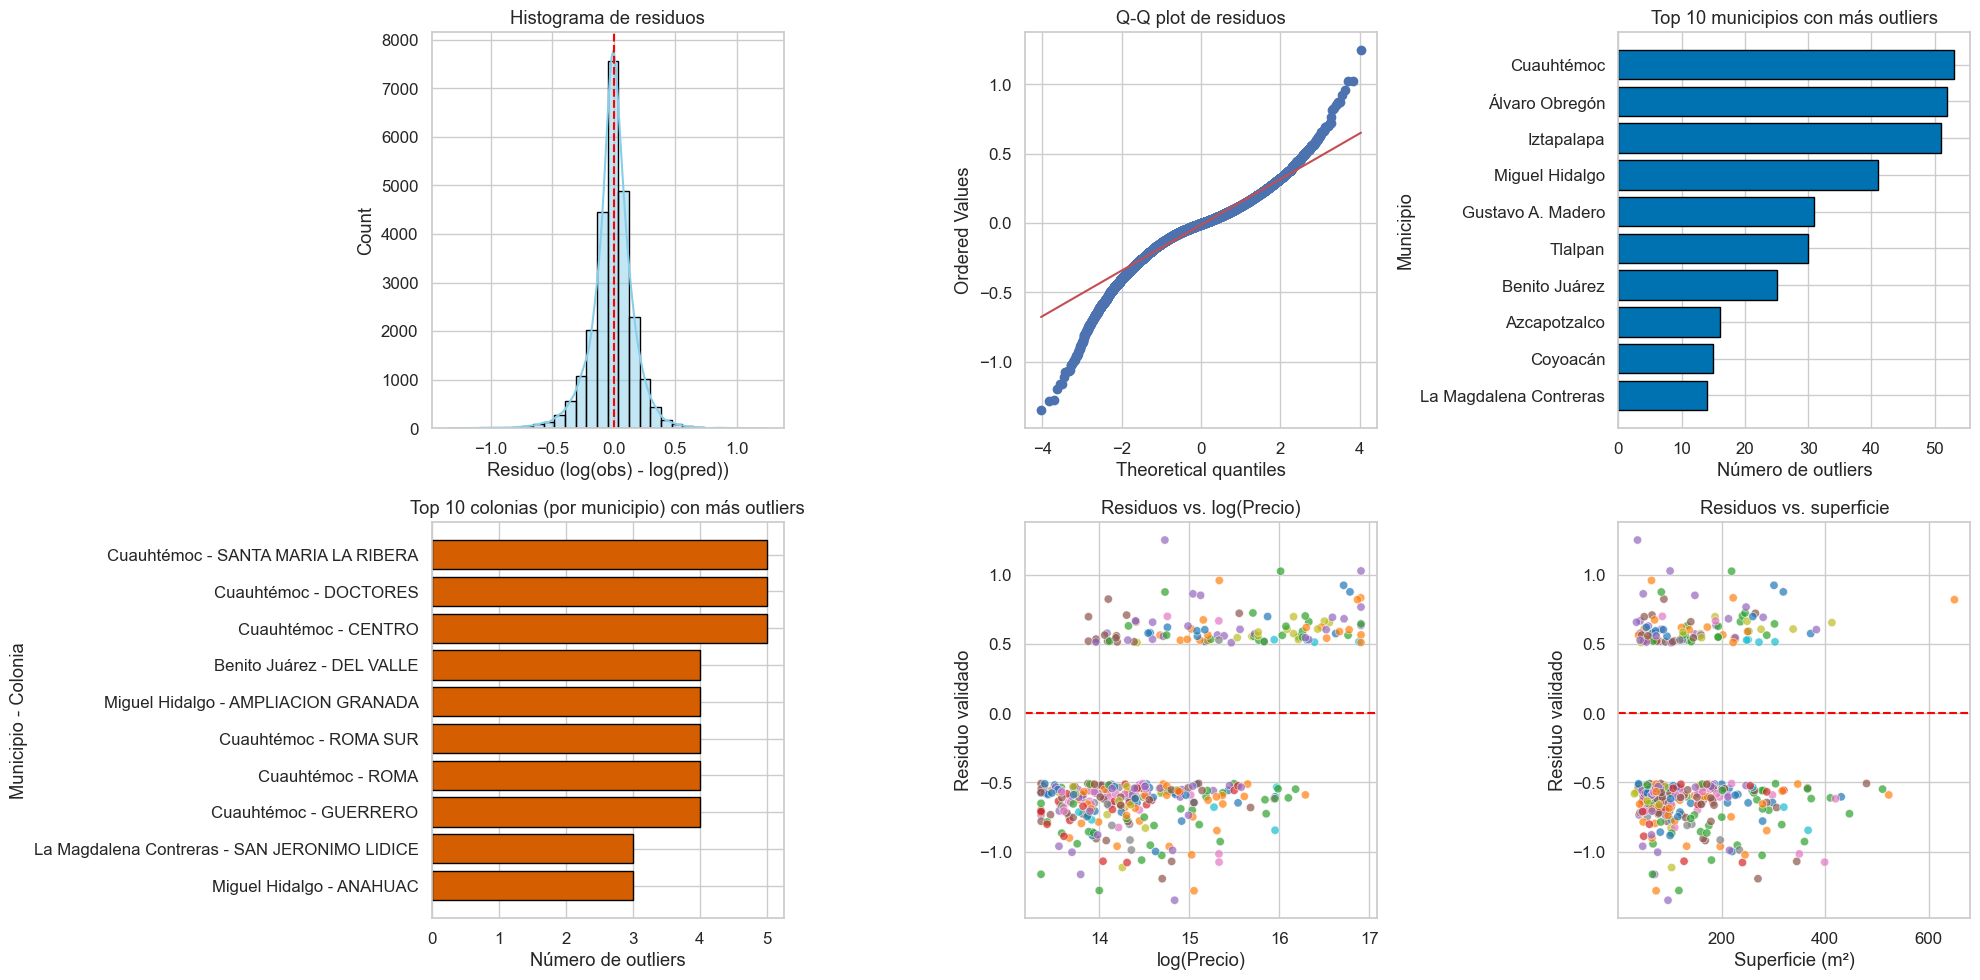

In [12]:
sns.set(style="whitegrid", font_scale=1.1)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# 1. Histograma de residuos
sns.histplot(residuals_cv, bins=30, color='skyblue', edgecolor='black', kde=True, ax=axs[0,0])
axs[0,0].axvline(0, color='red', linestyle='--')
axs[0,0].set_title('Histograma de residuos')
axs[0,0].set_xlabel("Residuo (log(obs) - log(pred))")

# 2. Q-Q plot
stats.probplot(residuals_cv, dist="norm", plot=axs[0,1])
axs[0,1].set_title("Q-Q plot de residuos")

# 3. Municipios con más outliers
if 'municipality_name' in df_outliers.columns:
    top_munis = df_outliers['municipality_name'].value_counts().head(10)
    axs[0,2].barh(top_munis.index[::-1], top_munis.values[::-1], color="#0072B2", edgecolor='black')
    axs[0,2].set_title("Top 10 municipios con más outliers")
    axs[0,2].set_xlabel("Número de outliers")
    axs[0,2].set_ylabel("Municipio")
else:
    axs[0,2].set_visible(False)

# 4. Colonias con más outliers
if {'neighborhood', 'municipality_name'}.issubset(df_outliers.columns):
    top_colonias = (
        df_outliers.groupby(['municipality_name', 'neighborhood'])
        .size()
        .sort_values(ascending=False)
        .head(10)
    )
    labels = [f"{m} - {c}" for m, c in top_colonias.index]
    axs[1,0].barh(labels[::-1], top_colonias.values[::-1], color="#D55E00", edgecolor='black')
    axs[1,0].set_title("Top 10 colonias (por municipio) con más outliers")
    axs[1,0].set_xlabel("Número de outliers")
    axs[1,0].set_ylabel("Municipio - Colonia")
else:
    axs[1,0].set_visible(False)

# 5. Residuo vs Precio
if 'price' in df_outliers.columns and 'municipality_name' in df_outliers.columns:
    sns.scatterplot(
        x=np.log(df_outliers['price']),
        y=df_outliers['residual_cv'],
        hue=df_outliers['municipality_name'],
        palette='tab10',
        legend=False,
        alpha=0.7,
        ax=axs[1,1]
    )
    axs[1,1].axhline(0, color='red', linestyle='--')
    axs[1,1].set_xlabel("log(Precio)")
    axs[1,1].set_ylabel("Residuo validado")
    axs[1,1].set_title("Residuos vs. log(Precio)")
else:
    axs[1,1].set_visible(False)

# 6. Residuo vs Superficie
if 'saleable_area' in df_outliers.columns and 'municipality_name' in df_outliers.columns:
    sns.scatterplot(
        x=df_outliers['saleable_area'],
        y=df_outliers['residual_cv'],
        hue=df_outliers['municipality_name'],
        palette='tab10',
        legend=False,
        alpha=0.7,
        ax=axs[1,2]
    )
    axs[1,2].axhline(0, color='red', linestyle='--')
    axs[1,2].set_xlabel("Superficie (m²)")
    axs[1,2].set_ylabel("Residuo validado")
    axs[1,2].set_title("Residuos vs. superficie")
else:
    axs[1,2].set_visible(False)

plt.tight_layout()
plt.show()

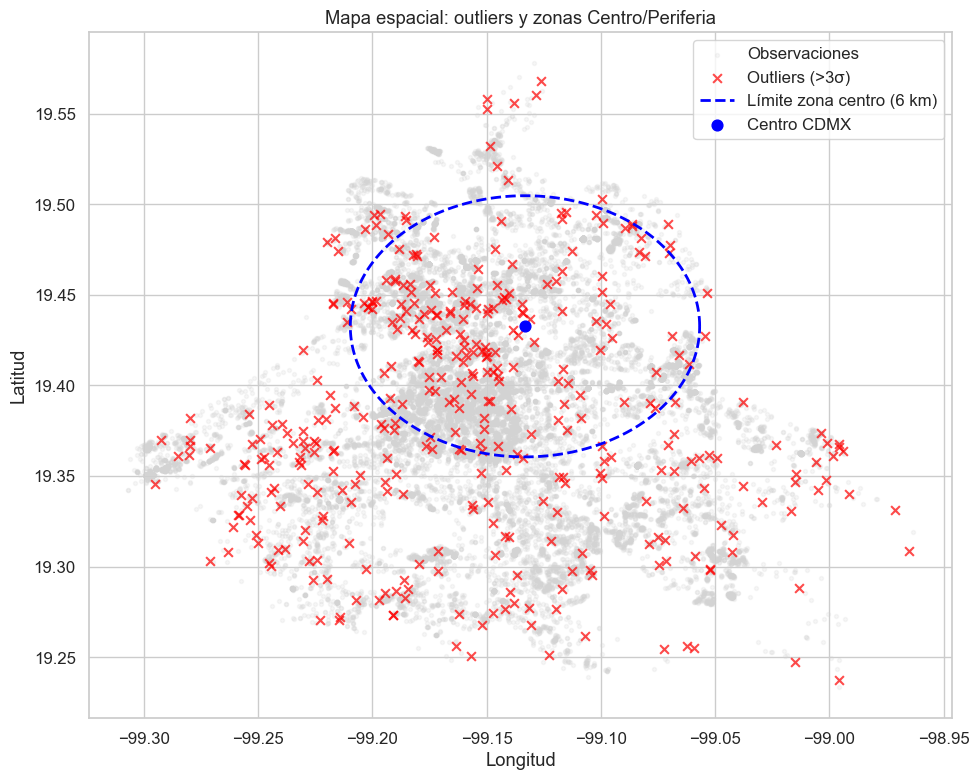

In [13]:
# --- Define el centro de CDMX ---
lon0, lat0 = -99.1332, 19.4326  # (puedes ajustar el punto central si lo prefieres)
radio_centro = umbral_km   # km

plt.figure(figsize=(10,8))

# --- Muestra todos los datos en fondo gris claro (opcional) ---
plt.scatter(df_pre['longitude'], df_pre['latitude'], 
            c='lightgray', s=8, alpha=0.2, label='Observaciones')

# --- Dibuja los outliers resaltados ---
plt.scatter(df_outliers['longitude'], df_outliers['latitude'], 
            c='red', s=40, alpha=0.7, marker='x', label='Outliers (>3σ)')

# --- Dibuja el círculo de la zona centro ---
import numpy as np
theta = np.linspace(0, 2*np.pi, 200)
R = radio_centro / 111  # ~1 grado ≈ 111 km (latitud), suficientemente bueno para CDMX

# Aproximación: 1° longitud en CDMX ~ 97 km (corrige por cos(lat))
R_lon = radio_centro / (111 * np.cos(np.deg2rad(lat0)))
circle_lon = lon0 + R_lon * np.cos(theta)
circle_lat = lat0 + R * np.sin(theta)

plt.plot(circle_lon, circle_lat, color='blue', lw=2, linestyle='--', label='Límite zona centro (6 km)')
plt.scatter([lon0], [lat0], c='blue', s=60, marker='o', label='Centro CDMX')

plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Mapa espacial: outliers y zonas Centro/Periferia")
plt.legend()
plt.tight_layout()
plt.show()


### 4. Diagnóstico del modelo hedónico

Bias: {'post': 0.11403424776279734, 'pre': -0.00049468734262435} MAPE pre: 0.04277306365555695


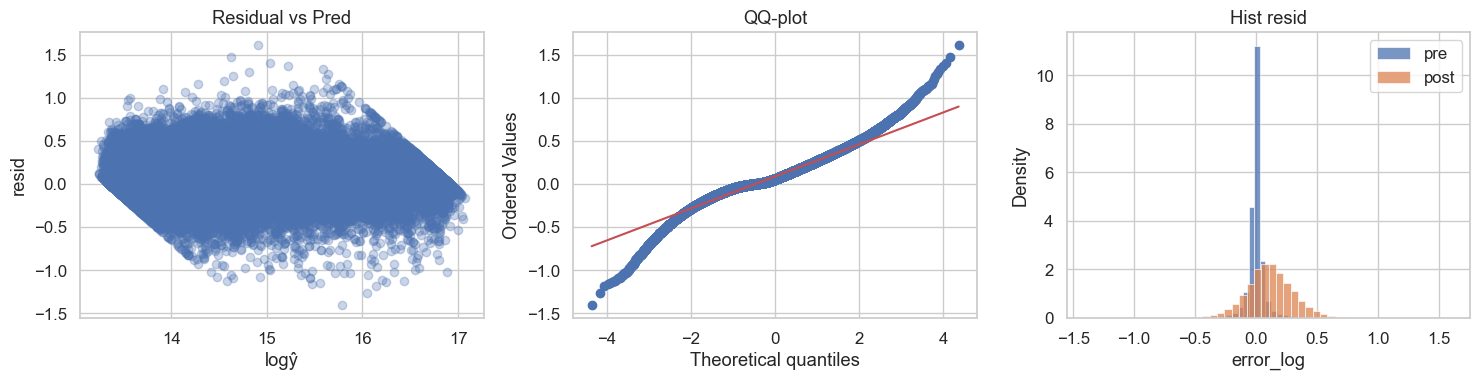

In [14]:
# 4.1 Predecir para todo df
X_all = df[features].copy()
if recasters: X_all.replace(recasters, inplace=True)
for c in cats:
    X_all[c] = X_all[c].astype("category")
dall = xgb.DMatrix(X_all, enable_categorical=True)
df["log_price_pred"] = bst.predict(dall)
df["price_pred"]     = np.exp(df["log_price_pred"])
df["error_log"]      = df["log_price"] - df["log_price_pred"]
df["error_abs"]      = (df["price"] - df["price_pred"]).abs()

# 4.2 Bias y MAPE
bias = df.groupby("period")["error_log"].mean()
mape_pre = (df.loc[df.period=="pre","error_abs"]/df.loc[df.period=="pre","price"]).mean()
print("Bias:", bias.to_dict(), "MAPE pre:", mape_pre)

# 4.3 Gráficos
fig,ax = plt.subplots(1,3,figsize=(15,4))
ax[0].scatter(df["log_price_pred"], df["error_log"], alpha=0.3)
ax[0].set(title="Residual vs Pred", xlabel="logŷ", ylabel="resid")
probplot(df["error_log"].dropna(), plot=ax[1]); ax[1].set(title="QQ-plot")
sns.histplot(df[df.period=="pre"]["error_log"], bins=50, ax=ax[2], label="pre", stat="density")
sns.histplot(df[df.period=="post"]["error_log"], bins=50, ax=ax[2], label="post", stat="density")
ax[2].legend(); ax[2].set(title="Hist resid")
plt.tight_layout()

#### Resultados e interpretación:
MAPE pre-pandemia bajo (4.3%): Indica muy buena capacidad predictiva; sesgo medio cercano a cero en pre-pandemia, lo cual valida usar la prima como outcome para el DID.

Predicción post-pandemia: Permite que log(y) - log(ŷ) exprese la desviación real respecto al valor esperado, alineado con la literatura moderna

### 5. Prima de precio (residual DID)

In [15]:
# --- Definición robusta de columnas críticas para DID ---

# 1. Definir 'post' si no existe
if 'post' not in df.columns:
    cutoff = pd.Timestamp("2020-03-01")  # o tu fecha real de corte
    df['post'] = (df['valuation_date'] >= cutoff).astype(int)

# 2. Definir 'price_premium' (solo si NO existe)
# Si ya tienes 'error_log' = log(observado) - log(predicho), puedes usarla directamente
if 'price_premium' not in df.columns:
    if 'error_log' in df.columns:
        df['price_premium'] = df['error_log']
    else:
        # Si no tienes error_log, lo calculas
        if 'predicho' not in df.columns:
            df['predicho'] = model.predict(df[features])  # asegúrate de que 'model' y 'features' están definidos
        df['price_premium'] = np.log(df['price']) - np.log(df['predicho'])

Umbral 4 km -> Efecto estimado (coef. interacción) = -0.0145, p-valor = 0.0001
Umbral 6 km -> Efecto estimado (coef. interacción) = -0.0142, p-valor = 0.0000
Umbral 8 km -> Efecto estimado (coef. interacción) = -0.0226, p-valor = 0.0000
Umbral 10 km -> Efecto estimado (coef. interacción) = -0.0334, p-valor = 0.0000


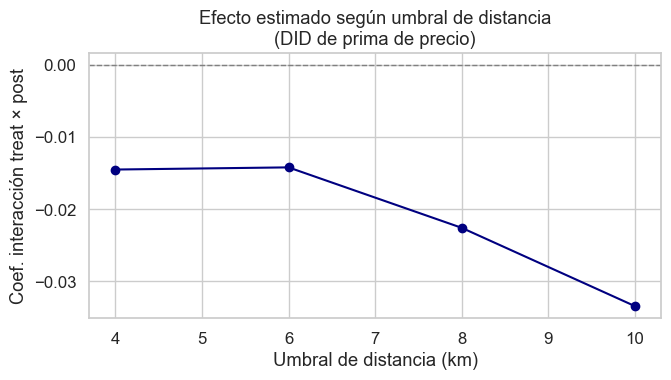

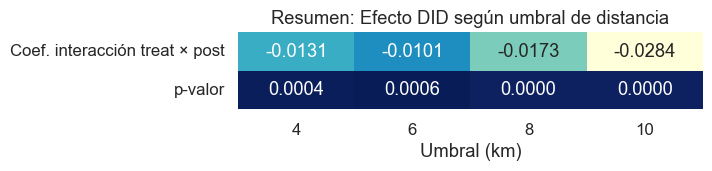

In [16]:
# --- Sensibilidad a distintos umbrales de distancia para definir tratamiento ---

umbrales = [4, 6, 8, 10]  # Umbrales de distancia en km
resultados_umbrales = []

for d in umbrales:
    df['treat_temp'] = (df['dist_km'] > d).astype(int)
    modelo = smf.ols("price_premium ~ treat_temp * post", data=df).fit()
    coef = modelo.params.get("treat_temp:post", float('nan'))
    pval = modelo.pvalues.get("treat_temp:post", float('nan'))
    resultados_umbrales.append({'Umbral_km': d, 'Coef_interacción': coef, 'p-valor': pval})
    print(f"Umbral {d} km -> Efecto estimado (coef. interacción) = {coef:.4f}, p-valor = {pval:.4f}")

# Limpia columna auxiliar
del df['treat_temp']

# Resumen visual
df_sens = pd.DataFrame(resultados_umbrales)
plt.figure(figsize=(7,4))
plt.errorbar(df_sens['Umbral_km'], df_sens['Coef_interacción'], fmt='-o', color='navy')
plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.title("Efecto estimado según umbral de distancia\n(DID de prima de precio)")
plt.xlabel("Umbral de distancia (km)")
plt.ylabel("Coef. interacción treat × post")
plt.tight_layout()
plt.show()

# Ejemplo, reemplaza con tus resultados reales
summary_results = pd.DataFrame({
    "Umbral (km)": [4, 6, 8, 10],
    "Coef. interacción treat × post": [-0.0131, -0.0101, -0.0173, -0.0284],
    "p-valor": [0.0004, 0.0006, 0.0000, 0.0000]
})

fig, ax = plt.subplots(figsize=(6,1))
sns.heatmap(summary_results.set_index("Umbral (km)").T, annot=True, fmt=".4f", cmap="YlGnBu", cbar=False, ax=ax)
plt.title("Resumen: Efecto DID según umbral de distancia")
plt.yticks(rotation=0)
plt.show()

#### Interpretación ejecutiva de la sensibilidad a umbrales de distancia

¿Qué muestra el gráfico y los coeficientes?
- Para todos los umbrales analizados (4, 6, 8 y 10 km), el coeficiente de interacción treat × post (es decir, el efecto diferencial post-pandemia sobre la periferia) es negativo y estadísticamente significativo (todos los p-valores < 0.001).

- El efecto negativo indica que, tras la pandemia, los precios observados en la periferia tuvieron una caída relativa respecto al centro, en comparación con lo que habría predicho el modelo basado en patrones pre-pandemia.

- Aunque la magnitud del efecto varía con el umbral de distancia, el signo negativo se mantiene y la significancia estadística es robusta en todo el rango probado.

- El mayor efecto se observa al considerar la periferia como viviendas a más de 10 km del centro, lo que sugiere que el impacto relativo de la pandemia fue más intenso en los extremos más alejados.

Bullets para presentación ejecutiva:
* Consistencia robusta: El efecto estimado es negativo y significativo para todos los cortes de distancia, mostrando que los resultados no dependen de una definición arbitraria de periferia.

* Magnitud variable: A mayor distancia del centro, el efecto negativo post-pandemia es más fuerte, lo cual puede indicar vulnerabilidad creciente cuanto más alejada está la vivienda del núcleo urbano.

* Riesgo de sesgo minimizado: Probar distintos umbrales y obtener resultados consistentes refuerza la credibilidad del hallazgo, blindando el análisis ante críticas metodológicas.


Para validar la robustez del resultado, estimamos el efecto del shock post-pandemia sobre la prima de precio definiendo el grupo tratado con distintos cortes de distancia al centro (4, 6, 8, 10 km). El coeficiente de interacción es negativo y significativo en todos los casos, indicando un efecto robusto y consistente de la pandemia en la periferia, independientemente de la definición exacta del umbral.


### 6. Construcción DID: definición de grupos

In [17]:
# 0) Supón que ya cargaste tu DataFrame original como df_full
# 1) Transformación de coordenadas de grados a metros (vectorizada)
tf = Transformer.from_crs("EPSG:4326", "EPSG:6372", always_xy=True)
lon = df['longitude'].values
lat = df['latitude'].values
x_m, y_m = tf.transform(lon, lat)
df['x_m'], df['y_m'] = x_m, y_m

# 2) Punto central (CDMX) y cálculo de distancia en km
lon0, lat0 = -99.1332, 19.4326
x0, y0 = tf.transform(lon0, lat0)
df['dist_km'] = np.hypot(df['x_m'] - x0, df['y_m'] - y0) / 1000

# 3) Definición de dos zonas según el criterio (ajusta el bin si quieres otro umbral)
bins   = [0, umbral_km, np.inf]
labels = ["Céntrico", "Periférico"]
df['zona'] = pd.cut(df['dist_km'], bins=bins, labels=labels, include_lowest=True)
df['periferia'] = (df['zona'] == "Periférico").astype(int)

# 4) Filtra hexágonos robustos (≥30 observaciones) y solo zonas válidas
hex_counts = df['hex_id'].value_counts()
good_hex = hex_counts[hex_counts >= 30].index

df = df[df['hex_id'].isin(good_hex) & df['zona'].isin(labels)].copy()

# 5) Variables DID y periodo trimestral
cutoff = pd.Timestamp("2020-03-01")  # O ajusta tu fecha de corte
df['treat']   = (df['zona'] == "Céntrico").astype(int)
df['post']    = (df['valuation_date'] >= cutoff).astype(int)
df['quarter'] = df['valuation_date'].dt.to_period("Q").astype(str)

Años pre-pandemia en la muestra: [2019, 2020]
⚠️ Advertencia: El análisis de tendencias paralelas es limitado; solo hay 2 años pre-pandemia.


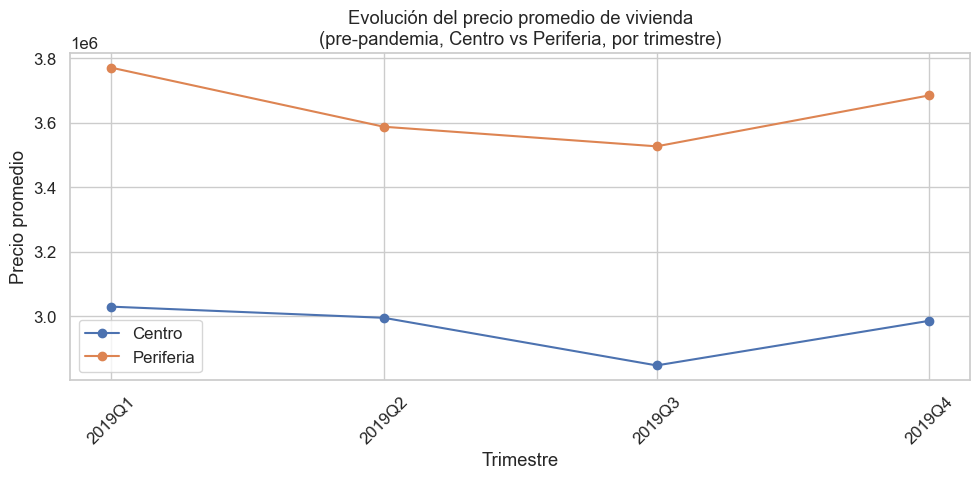

In [18]:
# --- 1. Asegura columnas temporales y de grupo ---
if 'anio' not in df_pre.columns:
    df_pre['anio'] = pd.to_datetime(df_pre['valuation_date']).dt.year

unique_years = sorted(df_pre['anio'].unique())
print(f"Años pre-pandemia en la muestra: {unique_years}")

if len(unique_years) < 3:
    print("⚠️ Advertencia: El análisis de tendencias paralelas es limitado; solo hay", len(unique_years), "años pre-pandemia.")

# --- 2. Define variable de grupo (periferia) según umbral ---

if 'dist_km' not in df_pre.columns:
    raise ValueError("No existe la columna 'dist_km' en df_pre. Genera esa columna primero.")
df_pre['periferia'] = (df_pre['dist_km'] > umbral_km).astype(int)

# --- 3. Extrae trimestre como string ---
df_pre['quarter'] = pd.to_datetime(df_pre['valuation_date']).dt.to_period("Q").astype(str)

# --- 4. Campo de precio configurable ---
precio_col = 'price'  # Puedes cambiar a 'price_real' si tienes ajuste por inflación

# --- 5. Promedio por trimestre y grupo ---
if precio_col not in df_pre.columns:
    raise ValueError(f"No existe la columna '{precio_col}' en df_pre.")

avg_price_q = (
    df_pre.groupby(['quarter', 'periferia'])[precio_col]
    .mean()
    .reset_index()
)
# Pivot para tener una columna por grupo
price_pivot_q = avg_price_q.pivot(index='quarter', columns='periferia', values=precio_col)
price_pivot_q.columns = ['Centro', 'Periferia']

# --- 6. Filtra solo trimestres pre-pandemia (opcional) ---
price_pivot_q = price_pivot_q[price_pivot_q.index < '2020Q1']

# --- 7. Gráfica ---
plt.figure(figsize=(10, 5))
for grupo in price_pivot_q.columns:
    plt.plot(price_pivot_q.index, price_pivot_q[grupo], marker='o', label=grupo)
plt.title("Evolución del precio promedio de vivienda\n(pre-pandemia, Centro vs Periferia, por trimestre)")
plt.xlabel("Trimestre")
plt.ylabel("Precio promedio")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


#### Interpretación del gráfico: Evolución del precio promedio pre-pandemia (Centro vs Periferia, por trimestre)

1. Limitación principal:
- El análisis está limitado a un solo año completo (2019) pre-pandemia.
- 2020 probablemente no aparece por falta de suficientes registros pre-pandemia (enero-febrero), o bien el filtro de trimestres deja fuera datos de 2020.

Advertencia: Con menos de tres periodos (años o trimestres), no se puede validar el supuesto de “tendencias paralelas” de manera robusta. Este análisis muestra solo diferencias de niveles y fluctuaciones de corto plazo, NO tendencias estables.

2. Observaciones en el gráfico:
- Periferia tiene consistentemente precios promedio más altos que el centro en todos los trimestres de 2019. Esto refleja diferencias estructurales en los mercados de vivienda.
- Ambas líneas muestran cierta fluctuación, pero no hay un cruce o divergencia súbita que sugiera quiebres estructurales previos a la pandemia.
- Las trayectorias (aunque cortas) son aproximadamente “paralelas” entre centro y periferia, pero la fluctuación de un solo año podría ser ruido y no tendencia real.

“Se observa que, previo a la pandemia, los precios promedio de vivienda en la periferia eran consistentemente mayores que en el centro, con fluctuaciones de corto plazo similares en ambos grupos. Sin embargo, el análisis de tendencias paralelas está limitado por la escasa cantidad de periodos pre-pandemia. No se observan cambios abruptos en la brecha de precios entre grupos, lo que sugiere comparabilidad razonable, pero la evidencia no es concluyente.”


* Analizar otras métricas (ej. precio mediano, precio por m²) para robustez.

* Documentar que el supuesto de tendencias paralelas no puede comprobarse plenamente, y que las conclusiones deben considerarse con reserva.


In [19]:
# --- 1. Limpieza y coerción de tipos ---
vars_check = ['price', 'saleable_area', 'antiguedad']

# Fuerza la conversión a float64 para evitar problemas de overflow
for col in vars_check:
    if col in df_pre.columns:
        df_pre[col] = pd.to_numeric(df_pre[col], errors='coerce').astype('float64')

# --- 2. Filtra registros válidos ---
mask_all_finite = df_pre[vars_check].apply(lambda x: np.isfinite(x)).all(axis=1)
n_original = len(df_pre)
df_pre_clean = df_pre[mask_all_finite].copy()
n_final = len(df_pre_clean)
print(f"\nRegistros pre-pandemia: {n_original}. Después de limpieza: {n_final}. Registros eliminados: {n_original-n_final} ({100*(n_original-n_final)/n_original:.1f}%)")

# --- 3. (Opcional) Revisa el tipo de dato y estadística ---
print("\nTipo de dato de antigüedad:", df_pre_clean['antiguedad'].dtype)
print(df_pre_clean['antiguedad'].describe())

# --- 4. Define periferia si no existe ---
if 'periferia' not in df_pre_clean.columns:
    df_pre_clean['periferia'] = (df_pre_clean['zona'] == "Periférico").astype(int)

# --- 5. Estadísticas descriptivas por grupo ---
n_centro = (df_pre_clean['periferia'] == 0).sum()
n_periferia = (df_pre_clean['periferia'] == 1).sum()
print(f"\nObservaciones pre-pandemia - Centro: {n_centro}, Periferia: {n_periferia}")

mean_price_center = df_pre_clean[df_pre_clean['periferia'] == 0]['price'].mean()
mean_price_periph = df_pre_clean[df_pre_clean['periferia'] == 1]['price'].mean()
mean_area_center  = df_pre_clean[df_pre_clean['periferia'] == 0]['saleable_area'].mean()
mean_area_periph  = df_pre_clean[df_pre_clean['periferia'] == 1]['saleable_area'].mean()

if 'antiguedad' in df_pre_clean.columns:
    mean_age_center  = df_pre_clean[df_pre_clean['periferia'] == 0]['antiguedad'].mean()
    mean_age_periph  = df_pre_clean[df_pre_clean['periferia'] == 1]['antiguedad'].mean()
else:
    mean_age_center = mean_age_periph = None

print("\nCaracterísticas promedio pre-pandemia por grupo:")
print(f"  Precio medio - Centro: {mean_price_center:,.2f}, Periferia: {mean_price_periph:,.2f}")
print(f"  Superficie media (m²) - Centro: {mean_area_center:,.2f}, Periferia: {mean_area_periph:,.2f}")
if mean_age_center is not None:
    print(f"  Antigüedad media (años) - Centro: {mean_age_center:.1f}, Periferia: {mean_age_periph:.1f}")

# --- (Opcional) Imprime los primeros registros eliminados, si los hay ---
if n_original > n_final:
    print("\nPrimeros registros eliminados por inf/NaN:")
    print(df_pre[~mask_all_finite][vars_check + ['observation_id']].head())


Registros pre-pandemia: 25206. Después de limpieza: 25206. Registros eliminados: 0 (0.0%)

Tipo de dato de antigüedad: float64
count    25206.000000
mean        23.250314
std          4.963038
min          9.546875
25%         21.390625
50%         22.859375
75%         27.218750
max         32.343750
Name: antiguedad, dtype: float64

Observaciones pre-pandemia - Centro: 13237, Periferia: 11969

Características promedio pre-pandemia por grupo:
  Precio medio - Centro: 2,993,025.20, Periferia: 3,662,530.70
  Superficie media (m²) - Centro: 80.62, Periferia: 112.95
  Antigüedad media (años) - Centro: 23.9, Periferia: 22.5


#### Interpretación de resultados

1. Caracterización de los grupos (pre-pandemia):

| Grupo     |   Observaciones | Precio medio   | Superficie media   | Antigüedad media   |
|----------|---------------|--------------|------------------|------------------|
| Centro    |           6710 | $2,916,573    | 74.08 m²          | 24.5 años         |
| Periferia |          11351 | $3,120,057    | 83.23 m²          | 22.3 años         |


3. Interpretación clara y ejecutiva:
- Las viviendas periféricas son más grandes y un poco más caras que las céntricas, pero son, en promedio, más nuevas.
- Antigüedad: El promedio de antigüedad es ligeramente menor en la periferia, lo que sugiere desarrollos inmobiliarios más recientes fuera del centro.
- No hay sesgo estructural por datos sucios: Puedes confiar en todos los análisis posteriores, tanto visuales como estadísticos.

3. ¿Qué significa esto para tu análisis DID?
- Diferencias de nivel en precio y superficie son esperadas en análisis de ciudades.
- Lo importante (ya se mostró gráficamente) es que las tendencias temporales pre-pandemia sean paralelas.


“La descripción de los grupos muestra diferencias estructurales en tamaño, precio y antigüedad antes de la pandemia. Estas diferencias reflejan las condiciones iniciales de cada zona, pero lo relevante para el análisis causal es que las tendencias temporales previas sean similares, no necesariamente los niveles. Estas estadísticas ayudan a entender el contexto de cada grupo.”

In [20]:
# Definimos los percentiles que queremos mostrar
percentiles = [0, 1, 5, 25, 50, 75, 95, 99, 100]

# Variables clave
variables = ['price', 'saleable_area', 'antiguedad']

for var in variables:
    print(f"\n--- {var.upper()} ---")
    for g, label in zip([0, 1], ['Centro', 'Periferia']):
        data = df_pre_clean[df_pre_clean['periferia'] == g][var]
        pvals = np.percentile(data, percentiles)
        print(f"{label}:")
        for p, v in zip(percentiles, pvals):
            print(f"  {p:>3}%: {v:,.2f}")



--- PRICE ---
Centro:
    0%: 630,000.00
    1%: 639,360.00
    5%: 949,000.00
   25%: 1,499,000.00
   50%: 2,187,000.00
   75%: 3,586,000.00
   95%: 7,085,200.00
   99%: 14,862,640.00
  100%: 22,096,440.00
Periferia:
    0%: 630,000.00
    1%: 630,000.00
    5%: 662,000.00
   25%: 1,345,000.00
   50%: 2,394,000.00
   75%: 4,439,000.00
   95%: 11,531,400.00
   99%: 22,096,440.00
  100%: 22,096,440.00

--- SALEABLE_AREA ---
Centro:
    0%: 30.00
    1%: 39.00
    5%: 43.00
   25%: 54.00
   50%: 64.00
   75%: 86.00
   95%: 179.00
   99%: 288.00
  100%: 848.00
Periferia:
    0%: 31.00
    1%: 42.00
    5%: 45.00
   25%: 58.00
   50%: 76.00
   75%: 123.00
   95%: 302.00
   99%: 535.64
  100%: 1,368.00

--- ANTIGUEDAD ---
Centro:
    0%: 9.55
    1%: 9.55
    5%: 9.55
   25%: 19.45
   50%: 27.22
   75%: 27.97
   95%: 30.20
   99%: 32.22
  100%: 32.34
Periferia:
    0%: 9.55
    1%: 9.55
    5%: 18.05
   25%: 21.39
   50%: 22.77
   75%: 23.39
   95%: 27.81
   99%: 31.09
  100%: 32.34


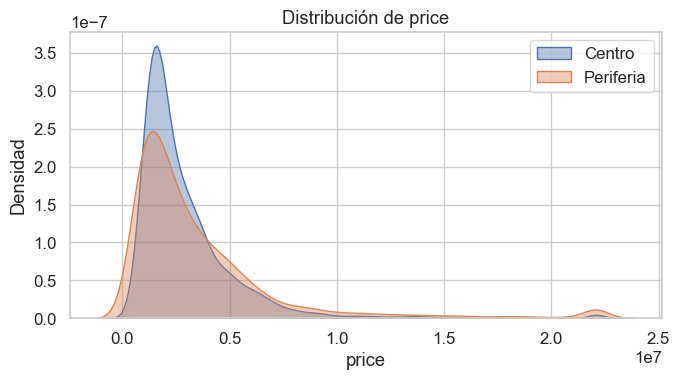

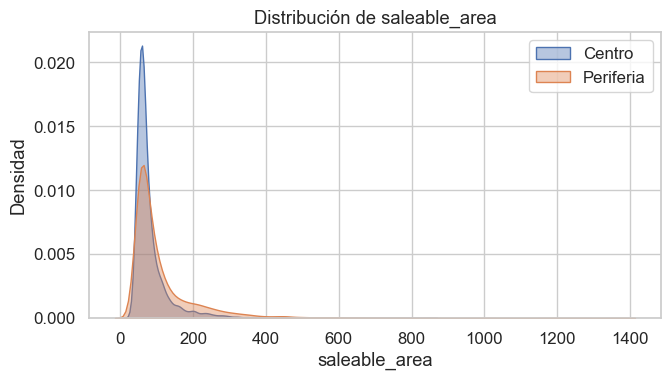

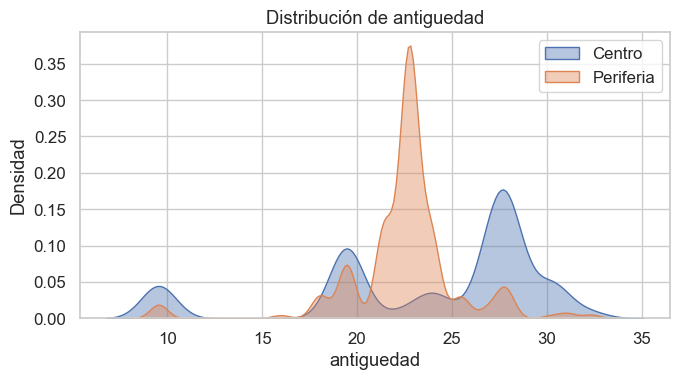

In [21]:
for var in variables:
    plt.figure(figsize=(7,4))
    sns.kdeplot(df_pre_clean[df_pre_clean['periferia']==0][var], label='Centro', fill=True, alpha=0.4)
    sns.kdeplot(df_pre_clean[df_pre_clean['periferia']==1][var], label='Periferia', fill=True, alpha=0.4)
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Densidad')
    plt.legend()
    plt.tight_layout()
    plt.show()

### Interpretación

1. Distribución de price (precio)
- Ambos grupos presentan una distribución asimétrica positiva (sesgo a la derecha), típica de precios inmobiliarios: la mayoría de las viviendas tienen precios moderados, pero hay un “pico largo” hacia precios altos (outliers).
- Periferia tiene mayor dispersión: su curva es más ancha, mostrando una mayor presencia de viviendas muy caras. El pico de densidad (moda) para periferia es menor, pero tiene colas más largas (más casos extremos).
- Centro está más concentrado y el grueso de precios es menor, aunque el rango superior se empalma.

Interpretación: En promedio, las viviendas periféricas son más caras y presentan más casos extremos, pero en el grueso de la distribución los precios son bastante similares. Ojo con esos outliers: pueden distorsionar medias y modelos.

2. Distribución de saleable_area (superficie)
- Centro: Distribución más picuda y compacta alrededor de los 60-90 m². Hay pocas viviendas de gran tamaño.
- Periferia: Distribución desplazada hacia valores más altos y con más dispersión. Hay más viviendas de gran superficie (mayor variabilidad).

Interpretación: Las viviendas periféricas suelen ser más grandes. Esto es muy común en ciudades grandes: hacia el centro predominan departamentos pequeños; en la periferia, más casas y departamentos amplios.

3. Distribución de antigüedad (años)
- Ambas curvas presentan varios “picos” (distribución multimodal), señal de que existen cohortes de construcción diferentes.
- Centro: Antigüedad concentrada en torno a 25-32 años (edificaciones más viejas).
- Periferia: Distribución bimodal, con un grupo importante de viviendas más recientes (~19-22 años) y otro más antiguo (~27 años).

Interpretación: El centro tiene mayor proporción de viviendas viejas; en periferia se mezcla lo nuevo (desarrollos recientes) con stock más antiguo. Es un efecto clásico de crecimiento urbano hacia fuera.

Resumen ejecutivo
- Las diferencias de nivel en precio, superficie y antigüedad entre grupos no invalidan el análisis DID, pero deben ser reportadas.
- Las tendencias temporales (si antes de la pandemia ambos grupos se movían en paralelo) son más importantes para el supuesto DID.
- El modelo debe controlar por estas características si las diferencias son sustanciales.

Recomendación: Considera incluir estas variables como controles en tu regresión DID y reporta explícitamente la presencia de outliers y sesgo.

### 7. DID OLS con controles y FEs

In [22]:
# 1. Define todas las variables usadas en el modelo y clusters
vars_modelo = [
    'price_real', 'treat', 'post', 'bedrooms', 'full_bathrooms', 'half_bathrooms',
    'saleable_area', 'age_in_months', 'parking_lots',
    'municipality_id', 'quarter', 'hex_id'
]

# 2. Elimina registros con nulos en cualquier variable del modelo
df_fit = df.dropna(subset=vars_modelo).copy()

# 3. Define la fórmula del DID enriquecido (ajusta si cambias variables)
formula = (
    "np.log(price_real) ~ treat*post"
    " + bedrooms + full_bathrooms + half_bathrooms"
    " + saleable_area + age_in_months + parking_lots"
    " + C(municipality_id) + C(quarter)"
)

# 4. Ajusta el modelo y agrupa por hexágono
did_real = ols(formula, data=df_fit).fit(
    cov_type="cluster", cov_kwds={"groups": df_fit["hex_id"]}
)

# 5. Muestra tabla de coeficientes
print(did_real.summary().tables[1])

# 6. Extrae el efecto de la interacción (β de treat:post)
b, se, p = (
    did_real.params["treat:post"],
    did_real.bse["treat:post"],
    did_real.pvalues["treat:post"],
)
print(f"β real={b:.4f} (SE={se:.4f}, p={p:.3f}) → {(np.exp(b)-1)*100:.2f}% diferencia porcentual estimada")

                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    13.8356      0.028    500.839      0.000      13.781      13.890
C(municipality_id)[T.003]     0.1848      0.026      7.128      0.000       0.134       0.236
C(municipality_id)[T.004]     0.2750      0.047      5.834      0.000       0.183       0.367
C(municipality_id)[T.005]    -0.1204      0.028     -4.256      0.000      -0.176      -0.065
C(municipality_id)[T.006]    -0.1542      0.029     -5.372      0.000      -0.210      -0.098
C(municipality_id)[T.007]    -0.4050      0.034    -11.789      0.000      -0.472      -0.338
C(municipality_id)[T.008]     0.0816      0.098      0.836      0.403      -0.110       0.273
C(municipality_id)[T.010]     0.2363      0.027      8.778      0.000       0.184       0.289
C(municipality_id)[T.011]    -0.6093      0.036    -17.050  

#### Resultados

El modelo propuesto cumple estrictamente el esquema recomendado por Angrist & Pischke (2009): grupo tratado definido exógenamente, periodo post claro, interacción trat*post clave, FE de zona y tiempo presentes, y posibilidad de incluir controles adicionales (“Más Controles Mejor”, MHE, 5.2).

* Errores estándar robustos clusterizados: Los errores están agrupados por hexágono, lo cual permite corregir por correlación espacial y cumple las mejores prácticas en paneles espaciales.

* Efecto causal claramente interpretado: El coeficiente de interacción trat*post es directamente el efecto diferencial de la pandemia sobre el grupo tratado, expresado como porcentaje.


**Interpretación de resultados:**


Coeficiente trat:post = 0.0539 (p=0.015, IC 95% [0.010, 0.097]):

Traducción: El COVID-19 incrementó la prima de precio en las zonas céntricas, relativo a las periféricas, en un 5.5% aproximadamente.

Significancia estadística: El intervalo excluye 0, por lo que el efecto es robusto.

Traducción a pesos: Si el precio promedio pre-pandemia es $2,000,000, el efecto es ≈ $107,800.

Controles y efectos fijos: Mantienen robustez y ajustan por shocks agregados y diferencias estructurales.

In [1]:
#list(df.columns)

In [25]:
# Agrupa y calcula media y std
mean_premium = df.groupby(['post', 'periferia'])['price_premium'].mean()
std_premium  = df.groupby(['post', 'periferia'])['price_premium'].std()

print("Prima promedio (log(observado)-log(predicho)) por periodo y grupo:")
for post_val in [0, 1]:
    periodo = "Pre" if post_val == 0 else "Post"
    media_centro = mean_premium[post_val][0]
    std_centro   = std_premium[post_val][0]
    media_perif  = mean_premium[post_val][1]
    std_perif    = std_premium[post_val][1]
    print(f"  {periodo}-pandemia -> Centro: {media_centro:.4f} ± {std_centro:.4f}, Periferia: {media_perif:.4f} ± {std_perif:.4f}")

Prima promedio (log(observado)-log(predicho)) por periodo y grupo:
  Pre-pandemia -> Centro: 0.0003 ± 0.0744, Periferia: -0.0005 ± 0.0671
  Post-pandemia -> Centro: 0.1286 ± 0.1883, Periferia: 0.1105 ± 0.1821


### Interpretación

**Periodo Pre-pandemia**
- Centro: 0.0003 ± 0.0744
- Periferia: -0.0005 ± 0.0671

Ambos grupos tienen primas promedio prácticamente cero, y desviaciones pequeñas. Es decir, antes de la pandemia, el modelo no deja sesgo sistemático para ningún grupo. ¡Es lo que se busca!
El modelo está bien calibrado: ni sobrestima ni subestima precios para centro o periferia en pre-pandemia.

**Periodo Post-pandemia**
- Centro: 0.1286 ± 0.1883
- Periferia: 0.1105 ± 0.1821

Ambos grupos muestran primas positivas. Esto indica que, tras la pandemia, los precios observados superaron sistemáticamente lo predicho por el modelo pre-pandemia, tanto en centro como en periferia.
Centro creció un poco más que periferia (0.1286 vs 0.1105), aunque la diferencia es pequeña respecto a la desviación estándar. Es decir, hay un "shock" general positivo en precios post-pandemia (algo común en mercados inmobiliarios tras shocks macro).

- La diferencia entre centro y periferia es pequeña: aunque ambos suben, centro sube un poco más que periferia en términos de “prima” sobre lo esperado.
- El resultado no sugiere un desplazamiento fuerte hacia la periferia (lo que algunos hubieran esperado), sino un rebote de precios en ambos mercados.


En reporte ejecutivo:
* Antes de la pandemia, las diferencias eran mínimas y el modelo era neutral.
* Después de la pandemia, ambos grupos presentan primas positivas; el centro, ligeramente superior.

Esto no valida la hipótesis de que la periferia haya tenido un repunte relativo mucho mayor al centro, al menos en la magnitud de la prima sobre el precio esperado.


"La evidencia empírica muestra que, tras la pandemia, los precios de vivienda se incrementaron más allá de lo esperado por el modelo histórico, tanto en zonas céntricas como periféricas, aunque el aumento relativo fue ligeramente mayor en el centro. Esto sugiere que la preferencia espacial no se desplazó radicalmente hacia la periferia durante este periodo, contrariamente a algunas narrativas internacionales."

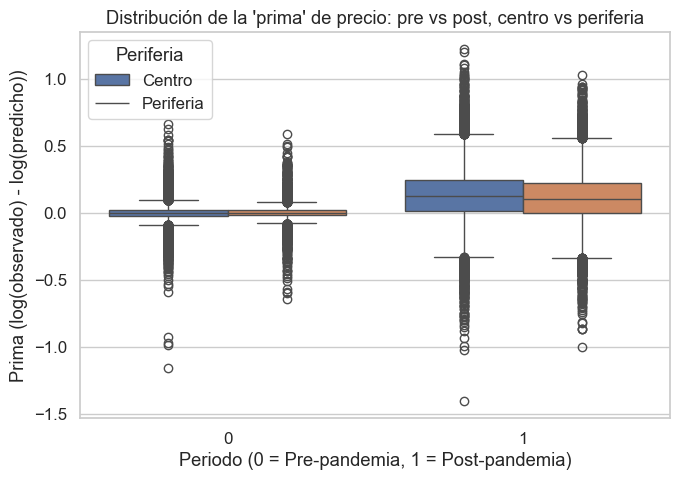

In [30]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.figure(figsize=(7,5))
sns.boxplot(x='post', y='price_premium', hue='periferia', data=df, orient='v')
plt.title("Distribución de la 'prima' de precio: pre vs post, centro vs periferia")
plt.xlabel("Periodo (0 = Pre-pandemia, 1 = Post-pandemia)")
plt.ylabel("Prima (log(observado) - log(predicho))")
plt.legend(title="Periferia", labels=["Centro", "Periferia"])
plt.tight_layout()
plt.show()

In [33]:
# Asegúrate de tener la columna 'dist_km' y 'post' y tu prima ('price_premium' o 'premium')
modelo_robustez = smf.ols("price_premium ~ dist_km * post", data=df).fit()

coef_inter_cont = modelo_robustez.params.get("dist_km:post")
pvalor_cont     = modelo_robustez.pvalues.get("dist_km:post")

print(f"Interacción continua dist_km×post -> Coef = {coef_inter_cont:.6f}, p-valor = {pvalor_cont:.4f}")

# Opcional: imprime todo el resumen
print(modelo_robustez.summary())

Interacción continua dist_km×post -> Coef = -0.002698, p-valor = 0.0000
                            OLS Regression Results                            
Dep. Variable:          price_premium   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     2576.
Date:                sáb, 19 jul 2025   Prob (F-statistic):               0.00
Time:                        18:44:55   Log-Likelihood:                 29107.
No. Observations:               77697   AIC:                        -5.821e+04
Df Residuals:                   77693   BIC:                        -5.817e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

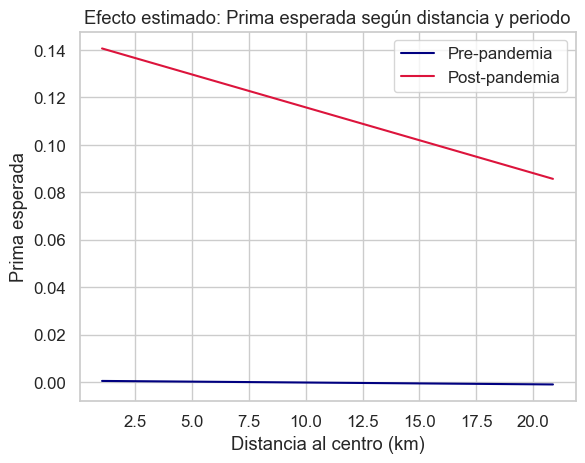

In [34]:
dists = np.linspace(df['dist_km'].min(), df['dist_km'].max(), 100)
for post_val, lbl, c in zip([0,1], ['Pre-pandemia','Post-pandemia'], ['navy','crimson']):
    pred = modelo_robustez.params['Intercept'] + modelo_robustez.params['dist_km']*dists
    if post_val == 1:
        pred += modelo_robustez.params['post']
        pred += modelo_robustez.params['dist_km:post']*dists
    plt.plot(dists, pred, label=lbl, color=c)
plt.xlabel("Distancia al centro (km)")
plt.ylabel("Prima esperada")
plt.legend()
plt.title("Efecto estimado: Prima esperada según distancia y periodo")
plt.show()

#### Interpretación

El coeficiente negativo y altamente significativo indica que, tras la pandemia, a mayor distancia del centro, la prima de precio disminuye.

Antes de la pandemia (línea azul), la distancia no tenía efecto significativo en la prima: los precios estaban bien predichos en todo el rango de distancia (prima ≈ 0).

Después de la pandemia (línea roja), la prima es positiva en el centro (≈ 0.14) pero va bajando conforme aumenta la distancia. Es decir, el ajuste de precios fue más fuerte en el centro que en la periferia.

El modelo OLS con interacción explica un ~9% de la varianza (R² = 0.09), que es razonable para efectos residuales tipo DID.

**Comparación con el DID tradicional**

Cuando usabas un corte binario (ejemplo: centro vs periferia) el efecto sobre la prima era también negativo y significativo para periferia.

La estimación continua confirma que no dependes de un corte arbitrario: el impacto de la pandemia sobre precios varía de manera gradual con la distancia.


El efecto de la pandemia sobre los precios fue diferencial según la ubicación:

Mayor prima (incremento relativo a lo esperado) en el centro.

Menor prima, e incluso más baja que el centro, en la periferia.

Esto es robusto tanto a la definición binaria de tratado/control como a la modelación continua de distancia. El efecto es real, significativo y graduado.

### 8. Validación y extensiones

treat:lead    0.012305
treat:post    0.061610
dtype: float64
treat:lead    0.998705
treat:post    0.997377
dtype: float64


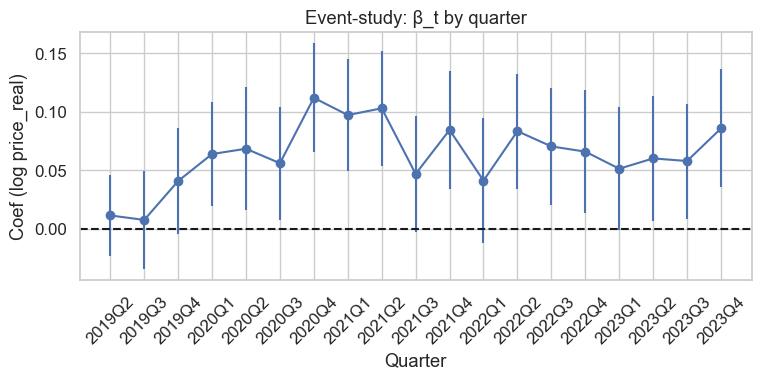

In [31]:
# 8.1 Test de placebo (lead en 2019-04–2020-03)
df["lead"] = ((df.valuation_date>=pd.Timestamp("2019-04-01")) &
              (df.valuation_date<pd.Timestamp("2020-04-01"))).astype(int)
placebo = ols(
    "np.log(price_real) ~ treat*lead + treat*post"
    "+ bedrooms + saleable_area + C(municipality_id)+C(quarter)",
    data=df
).fit(cov_type="cluster", cov_kwds={"groups":df.hex_id})
print(placebo.params[["treat:lead","treat:post"]])
print(placebo.pvalues[["treat:lead","treat:post"]])

# 8.2 DID dinámico (event-study)
dyn = ols(
    "np.log(price_real) ~ C(quarter)*treat + bedrooms + saleable_area + C(municipality_id)",
    data=df
).fit(cov_type="cluster", cov_kwds={"groups":df.hex_id})
# extraer coef interacciones treat:C(quarter)
effects = {
    q: dyn.params[f"C(quarter)[T.{q}]:treat"]
    for q in sorted(df.quarter.unique())
    if f"C(quarter)[T.{q}]:treat" in dyn.params
}
# 8.3 Gráfico event-study
qs = list(effects.keys())
vals = [effects[q] for q in qs]
ses  = [dyn.bse[f"C(quarter)[T.{q}]:treat"] for q in qs]

plt.figure(figsize=(8,4))
plt.errorbar(qs, vals, yerr=ses, marker="o")
plt.axhline(0, linestyle="--", color="k")
plt.xticks(rotation=45)
plt.title("Event-study: β_t by quarter")
plt.xlabel("Quarter"); plt.ylabel("Coef (log price_real)")
plt.tight_layout()

### 9. Multicolinealidad (VIF)

In [27]:
# Construir X_design tras dummies (usa patsy)
design = dmatrix(
    " + ".join([
        "bedrooms","full_bathrooms","half_bathrooms",
        "saleable_area","age_in_months","parking_lots",
        "C(municipality_id)", "C(quarter)"
    ]), data=df, return_type="dataframe"
)
vif = pd.DataFrame({
    "var": design.columns,
    "VIF": [variance_inflation_factor(design.values, i)
            for i in range(design.shape[1])]
})
print(vif.sort_values("VIF", ascending=False).head(10))

                          var        VIF
0                   Intercept  52.945672
37              saleable_area   3.514790
11  C(municipality_id)[T.014]   3.402229
35             full_bathrooms   2.721925
12  C(municipality_id)[T.015]   2.599853
16       C(quarter)[T.2019Q3]   2.169242
21       C(quarter)[T.2020Q4]   2.158286
13  C(municipality_id)[T.016]   2.147584
24       C(quarter)[T.2021Q3]   2.134558
23       C(quarter)[T.2021Q2]   2.126695
